
### 背景
研究影响用户流失的主要因素
### 初步结论
* 影响用户流失的主要因素依次为：平均客单价、客单价的波动情况、T用户的波动情况、历史购买间隔的波动情况、沉默时长、单量、最高配送费、用户经历超时所带来伤害打分。
* T用户的波动情况体现了服务的稳定性，是我们以后提升服务质量的一个方向。
* 用户经历超时所带来的伤害打分在此次研究模型并没有对用户流失带来很大的影响。
### 研究过程
#### Part1: 定义流失
用户前一周在饿了么平台点餐，如果接下来的一周没有继续在饿了么点餐的用户，那么这个用户就流失了。
#### Part2: 指标选取
设定用户观测周期为2017/03/27-2017/10/09（半年时间）
样本选取了上海一个团队（team_id=6204025）在2017／10／09～2017／10／15所服务的所有用户在接下来一周（2017／10/16~2017/10/22）是否流失。
* user_id:                 用户ID
* is_churn:                用户是否流失
* last_to_end:             沉默时长：用户下最后一单距观测周期结束的天数
* order_cnt:               单量：用户在观测周期内的下单总量
* price:                   用户实际支付总价
* avg_order_price:         客单价（实际支付总价／单量）
* complain_cnt:            用户经历的投诉单总量
* bad_comment_cnt:         用户经历的差评单总量
* max_delivery_fee:        最高配送费
* overtime_damage_cnt:     用户经历的超时单总量
* overtime_damage_score:   用户经历超时单所带来的伤害打分
* total_overtime_time:     用户经历超时单的超时部分总时长
* cancel_damage_cnt:       用户经历超时取消单总量
* cancel_damage_score:     用户经历超时取消单所带来的伤害打分
* total_cancel_wait_time:  用户经历超时取消单所等待的总时长
* std_Tuser:               T用户的波动情况（方差）
* std_price:               客单价的波动情况（方差）
* std_order_interval:      历史购买间隔的波动情况（方差）

其中，在计算用户经历超时单所带来的伤害打分时，首先把超时单分为4个等级：小于11分钟、11-20分钟、21-45分钟、大于45分钟，然后对4个等级的伤害等级赋权重：（1，4，8，18），权重乘以单量就是最总的伤害打分。权重的设定根据各个不同等级的超时在人群中的占比定义。用户经历超时取消单所带来的伤害打分也是同样的计算逻辑，其对应的权重为：（1，7，14，61）。
### 研究方法
使用XGBoost训练模型，找到对流失影响比较大的因素

### 改进方向
#### 缺点
* 选取更多的样本，使用isolation forest 去除异常值
* 添加更多的因变量，比如赔付红包的信息、平台红包信息、以及其他用户相关的信息
#### 方向
* 希望通过用户流失的研究，可以对红包赔付有一些指导意义
*


### 数据认知

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
user_churn=pd.read_excel('/Users/ymzhang/Desktop/user_churn.xlsx',sheetname='Sheet0',index_col='user_id')

In [44]:
user_churn.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10996 entries, 519975.0 to 447207922.0
Data columns (total 18 columns):
is_churn                  10996 non-null int64
last_to_end               10995 non-null float64
order_cnt                 10995 non-null float64
overtime_damage_socre     10995 non-null float64
overtime_damage_cnt       10995 non-null float64
total_overtime_time       10995 non-null float64
cancel_damage_score       10995 non-null float64
cancel_damage_cnt         10995 non-null float64
total_cancel_overtime     10995 non-null float64
total_cancel_wait_time    10995 non-null float64
price                     10995 non-null float64
avg_order_price           10995 non-null float64
user_complain_cnt         10995 non-null float64
max_deliver_fee           10995 non-null float64
bad_comment_cnt           10995 non-null float64
std_tuser                 10995 non-null float64
std_price                 10995 non-null float64
std_order_interval        10871 non-null floa

In [45]:
user_churn.head()

,is_churn,last_to_end,order_cnt,overtime_damage_socre,overtime_damage_cnt,total_overtime_time,cancel_damage_score,cancel_damage_cnt,total_cancel_overtime,total_cancel_wait_time,price,avg_order_price,user_complain_cnt,max_deliver_fee,bad_comment_cnt,std_tuser,std_price,std_order_interval
user_id,,,,,,,,,,,,,,,,,,
519975.0,1,9.0,2.0,0.0,0.0,0.0,1.0,1.0,6.9,38.9,32.00,16.00,0.0,4.0,0.0,10.0,0.10,0.5
775063.0,0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.20,34.20,0.0,6.0,0.0,0.0,0.00,0.0
841831.0,0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,50.00,0.0,5.0,0.0,0.0,0.00,0.0
1145604.0,0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.00,38.00,0.0,5.0,0.0,0.0,0.00,0.0
2010592.0,0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.28,26.64,0.0,5.0,0.0,7.5,1.64,1.0


In [46]:
cols=user_churn.columns[1:]
df1=user_churn[user_churn.is_churn==0]
df2=user_churn[user_churn.is_churn==1]

** 空值情况 **

In [47]:
user_churn.isnull().sum()

is_churn                    0
last_to_end                 1
order_cnt                   1
overtime_damage_socre       1
overtime_damage_cnt         1
total_overtime_time         1
cancel_damage_score         1
cancel_damage_cnt           1
total_cancel_overtime       1
total_cancel_wait_time      1
price                       1
avg_order_price             1
user_complain_cnt           1
max_deliver_fee             1
bad_comment_cnt             1
std_tuser                   1
std_price                   1
std_order_interval        125
dtype: int64

In [48]:
user_churn.dropna(how='any',inplace=True) ##去掉空值

In [49]:
user_churn.is_churn.value_counts()

0    7898
1    2973
Name: is_churn, dtype: int64

** 流失用户有2973个，非流失用户有7898个 **

** 建立XGBoost模型 **

In [50]:
from sklearn import model_selection, preprocessing 
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
train_y=user_churn.is_churn.values
train_x=user_churn.drop(['is_churn'],axis=1)
xgb_params = {
    'eta':0.05,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'binary:logistic',
    'eval_metric':'error'
}
dtrain=xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
model=xgb.train(xgb_params, dtrain, num_boost_round=50)

                 features  importance
2                   price         470
9         avg_order_price         468
5               std_price         277
8     total_overtime_time         271
1               std_tuser         233
10     std_order_interval         229
4             last_to_end         222
0               order_cnt         146
3         max_deliver_fee          98
6   overtime_damage_socre          73
7     overtime_damage_cnt          40
11        bad_comment_cnt           2
12    cancel_damage_score           1


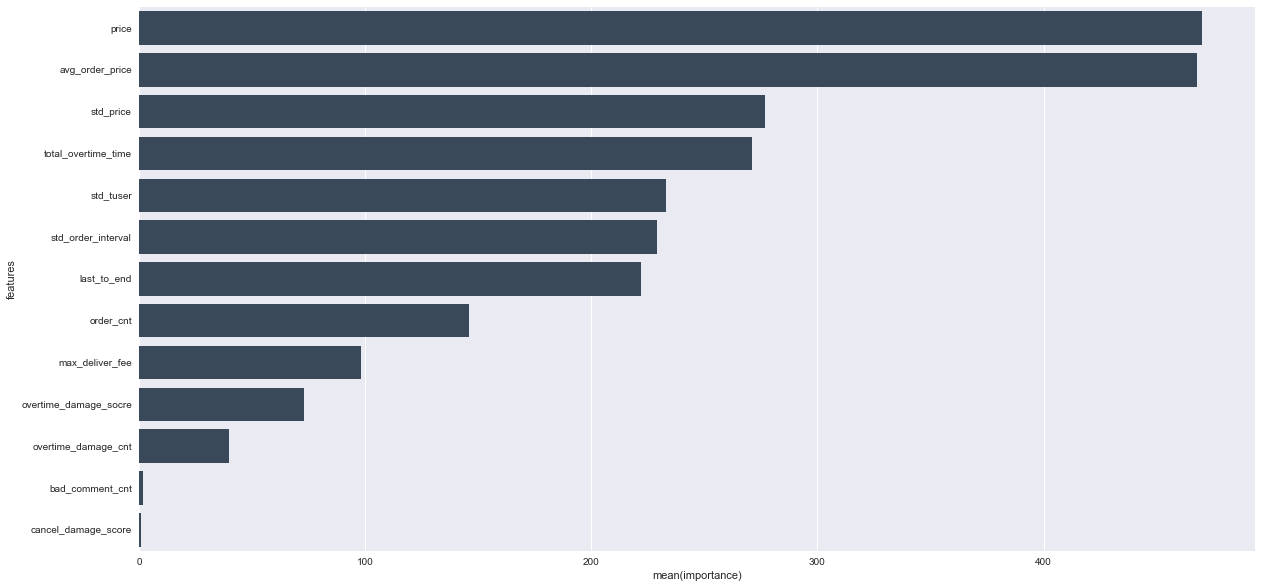

In [51]:
featureImportance=model.get_fscore()
features=pd.DataFrame()
features['features']=featureImportance.keys()
features['importance']=featureImportance.values()
features.sort_values(by='importance',ascending=False,inplace=True)
print(features)
fig, ax=plt.subplots(figsize=(20,10))
sns.barplot(x='importance',y='features',data=features,ax=ax,orient='h',color='#34495e')

模型最终选取了13个变量，变量的总要性排名如上。接下来分析一下这些重要变量的线性关系。

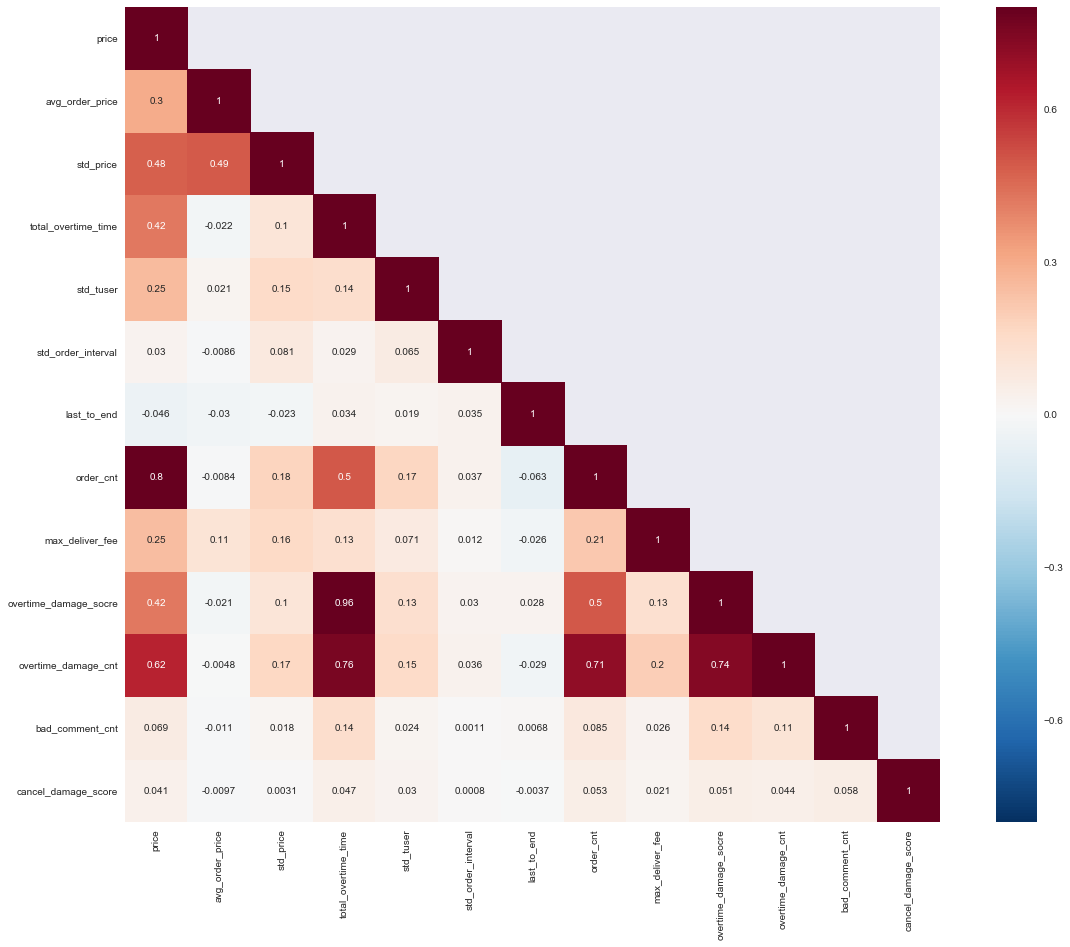

In [52]:
topFeatures=features['features'].tolist()
corrmatrix=user_churn[topFeatures].corr()
mask=np.array(corrmatrix)
mask[np.tril_indices_from(mask)]=False
f, ax=plt.subplots(figsize=(20,15))
sns.heatmap(corrmatrix, vmax=.8,mask=mask, annot=True,square=True)

** price 和 order_cnt、overtime_damage_cnt 的相关性大于0.6，order_cnt与total_overtime_time的相关性达到0.5，overtime_damage_score与total_overtime_time的相关性达到0.96，overtime_damage_cnt与total_overtime_time、order_cnt、price、overtime_damage_score相关性达到0.7。因此决定去掉price、overtime_damage_cnt、total_overtime_time。**

In [53]:
features=features[~features.features.isin(['price','total_overtime_time','overtime_damage_cnt'])]
features

,features,importance
9,avg_order_price,468
5,std_price,277
1,std_tuser,233
10,std_order_interval,229
4,last_to_end,222
0,order_cnt,146
3,max_deliver_fee,98
6,overtime_damage_socre,73
11,bad_comment_cnt,2
12,cancel_damage_score,1


** 观测这些选出来的重要变量与因变量（是否流失，1:流失，0:没有流失）之间的关系。**

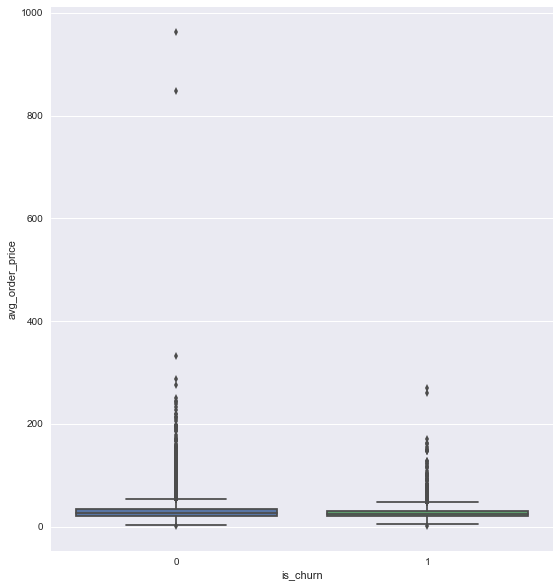

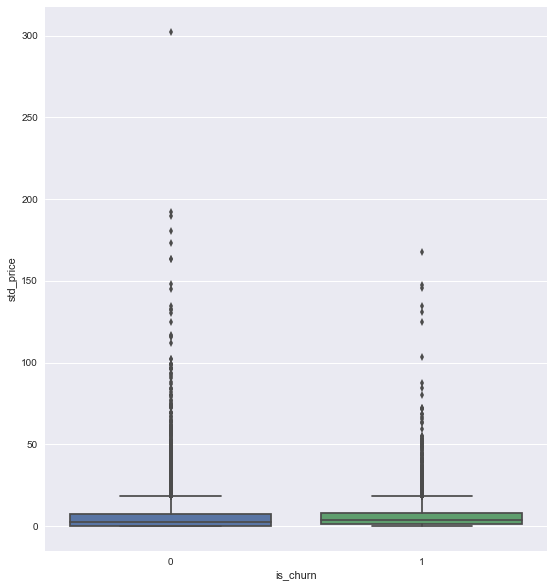

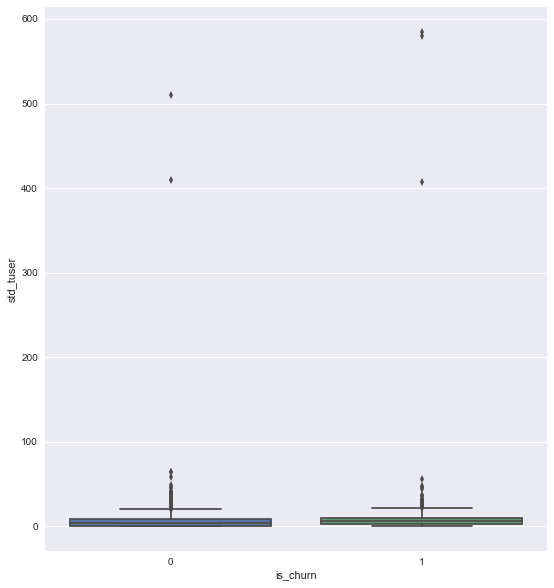

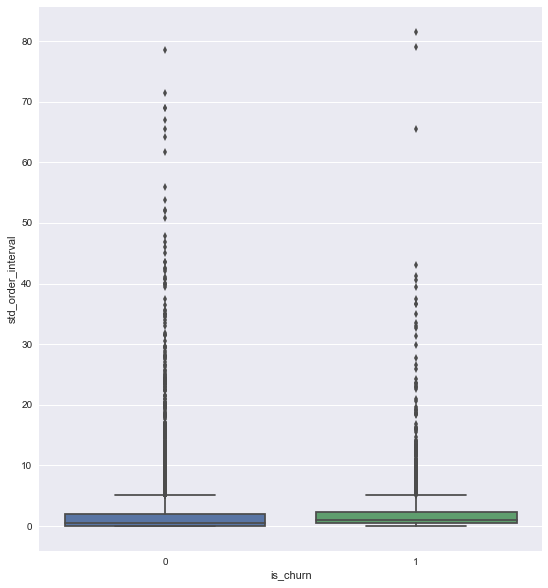

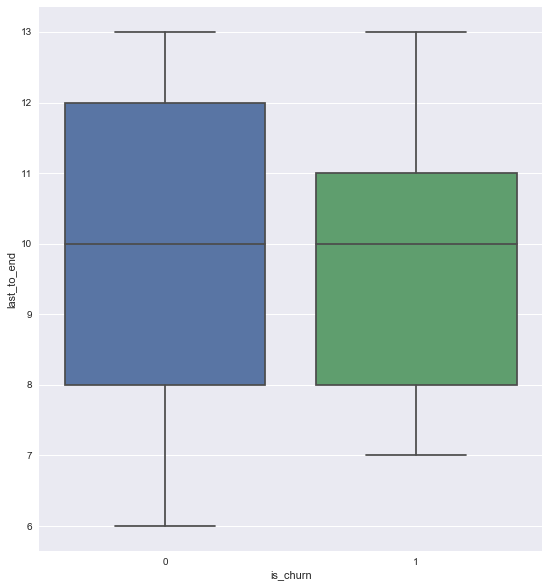

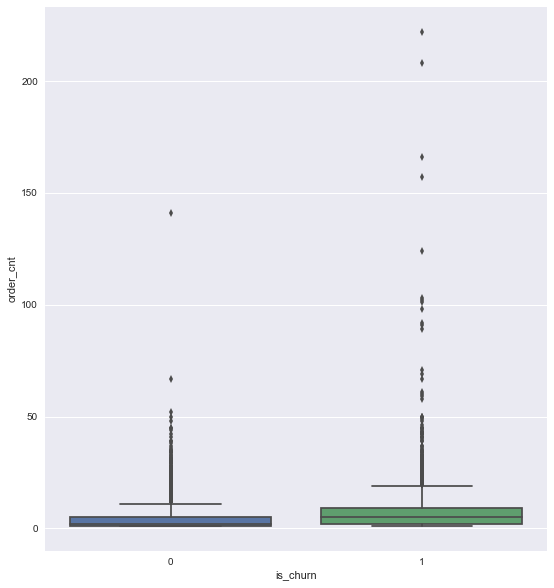

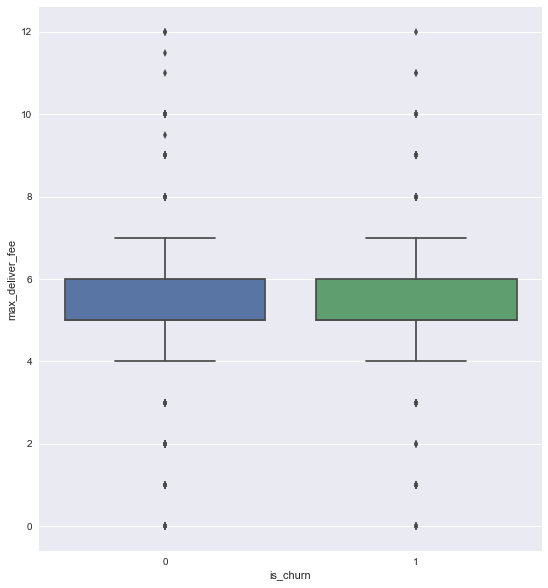

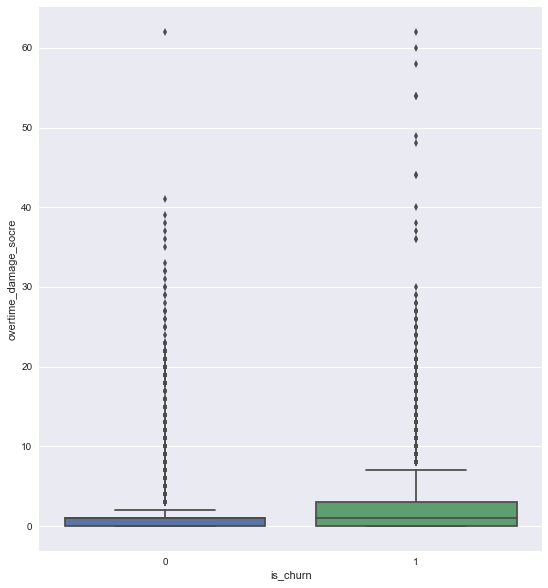

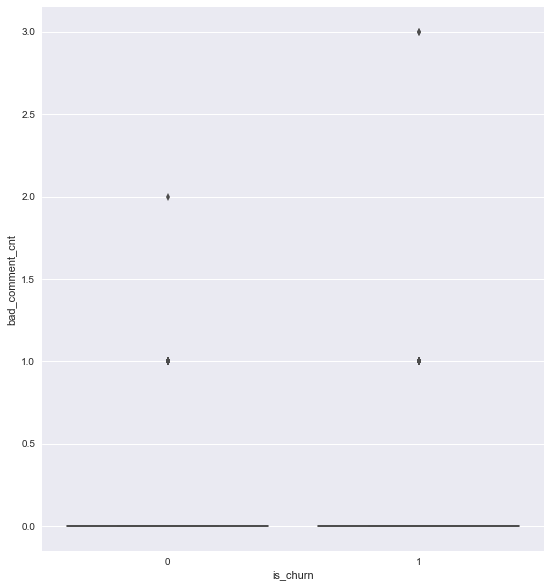

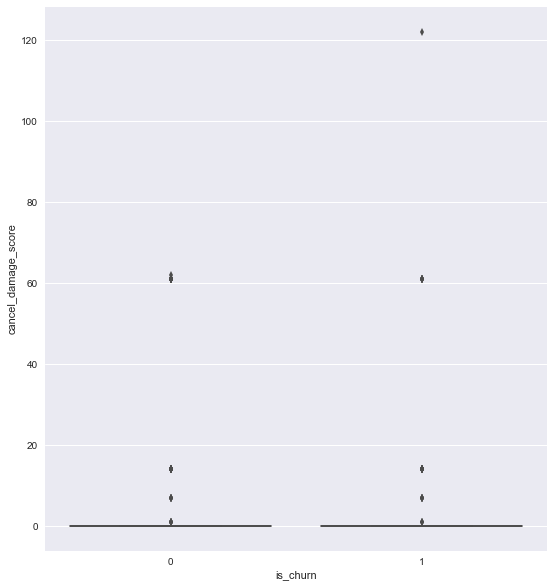

In [54]:
for col in features.features.values:
    fig, ax=plt.subplots(figsize=(9,10))
    sns.boxplot(y=col,x='is_churn',data=user_churn)

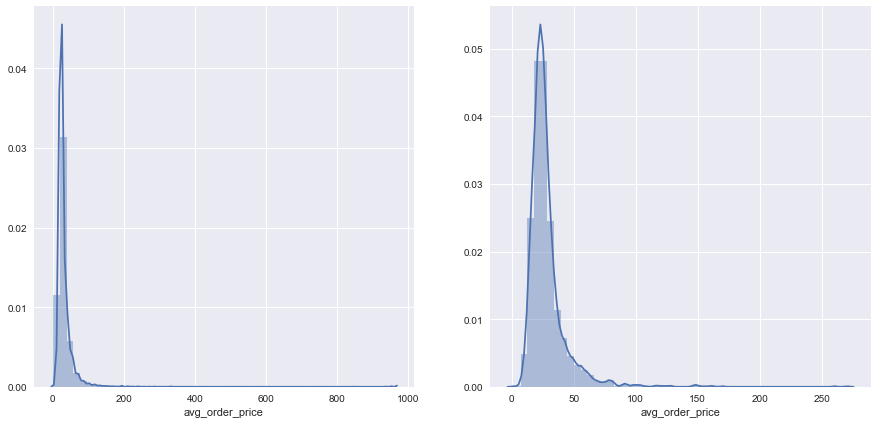

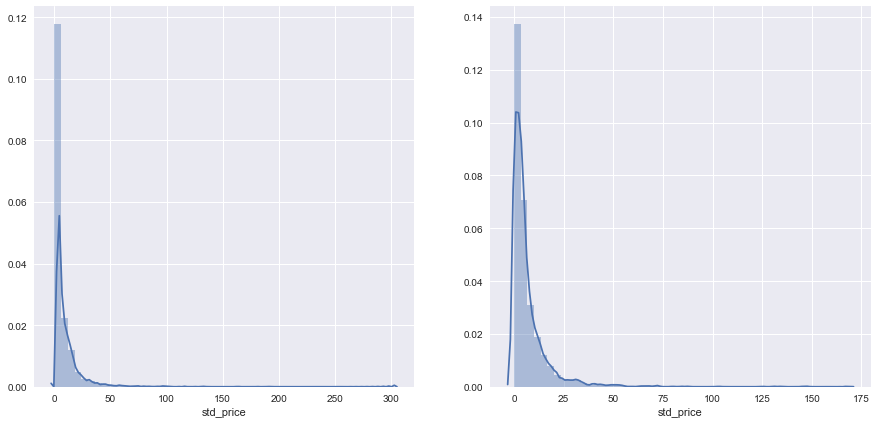

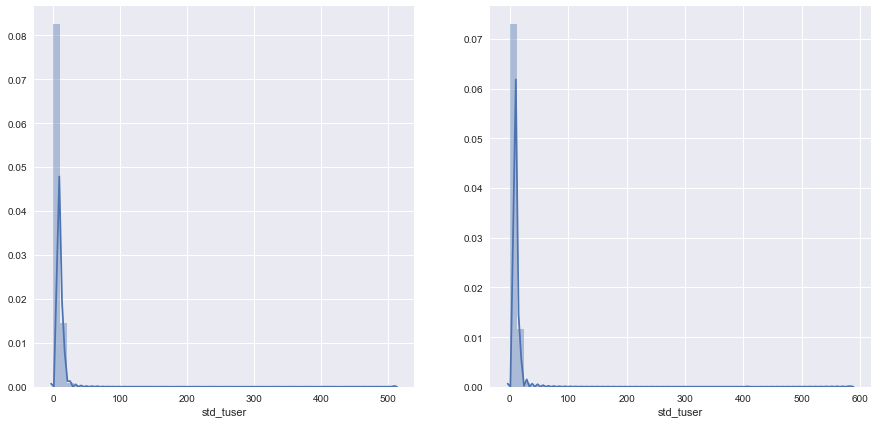

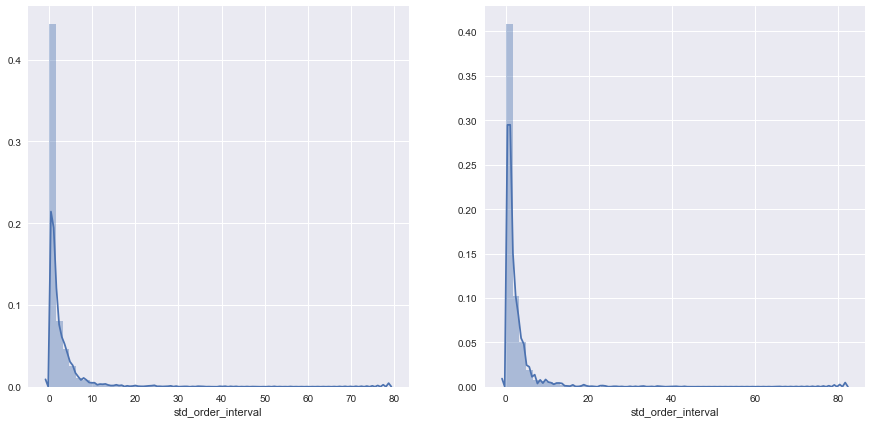

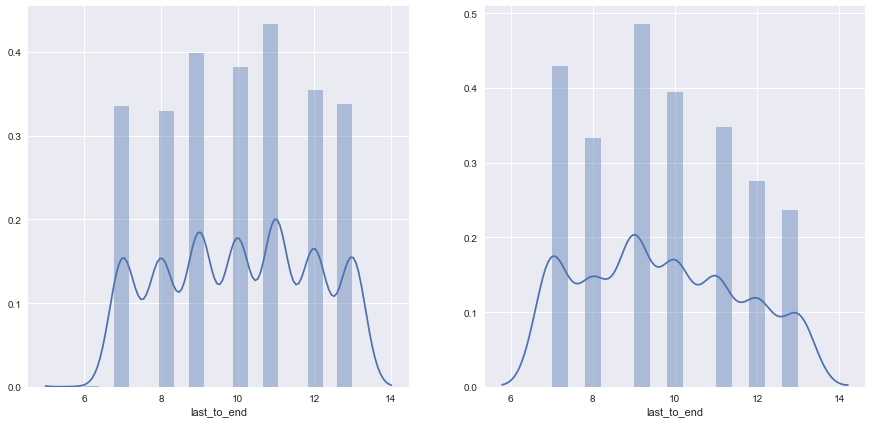

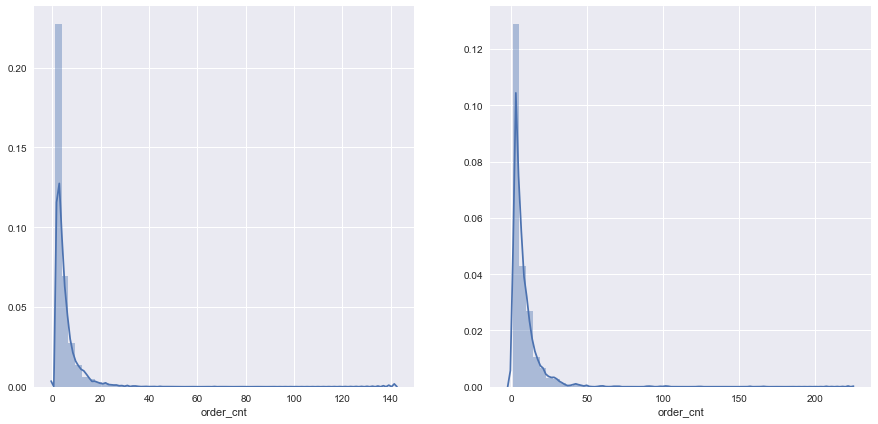

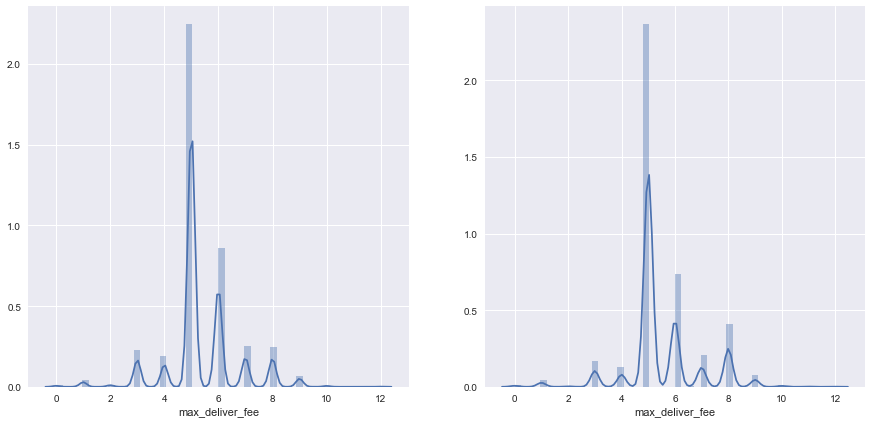

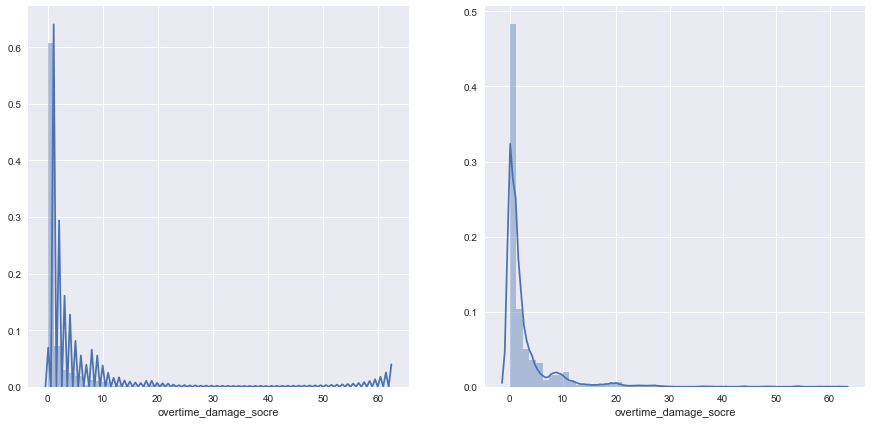

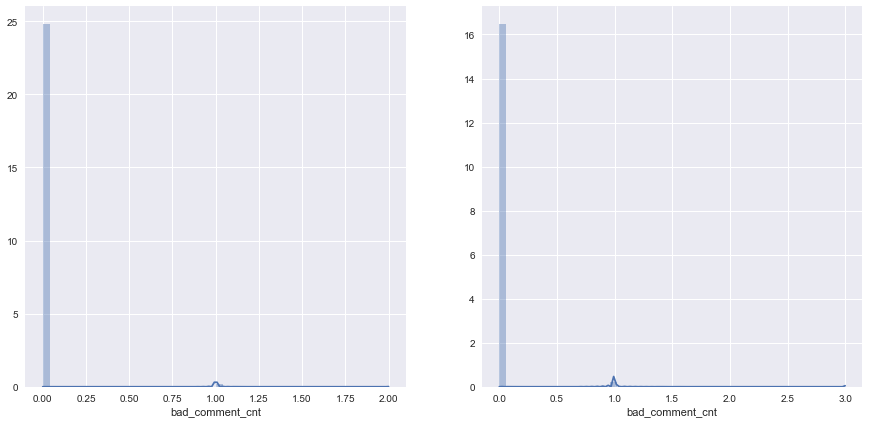

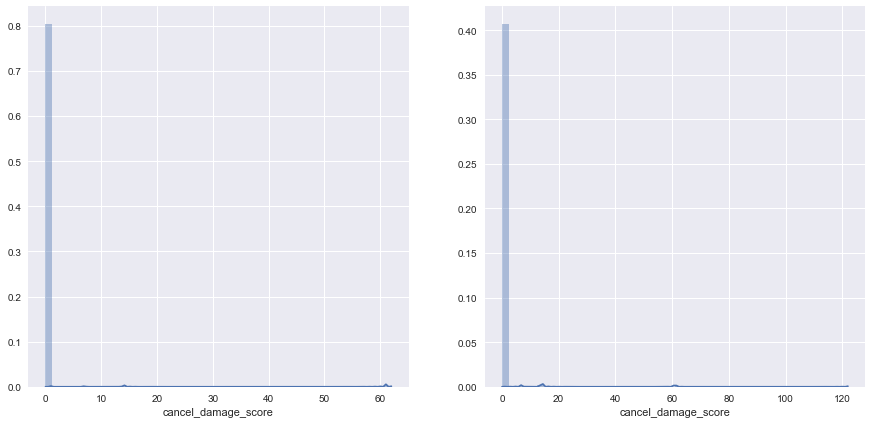

In [55]:

for col in features.features.values:
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    sns.distplot(df1[col].dropna(),label='non_churn')
    plt.subplot(1,2,2)
    sns.distplot(df2[col].dropna(),label='churn')

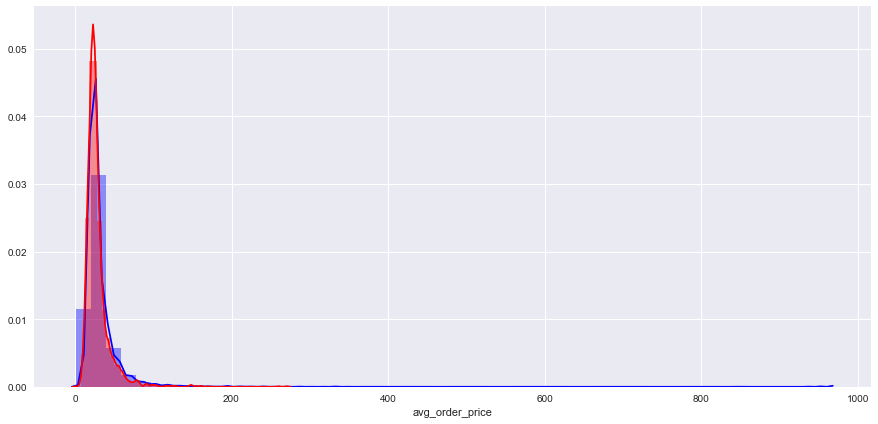

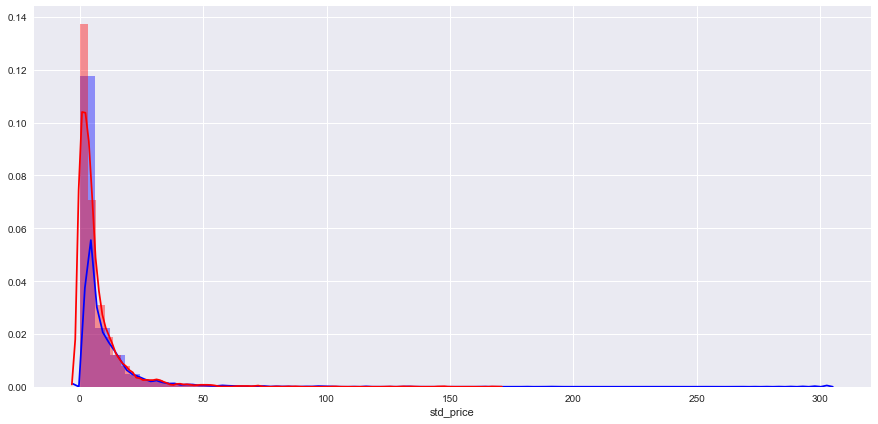

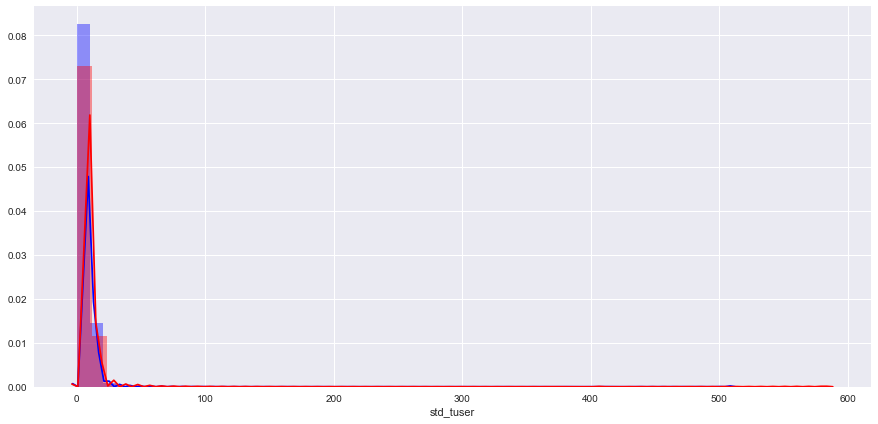

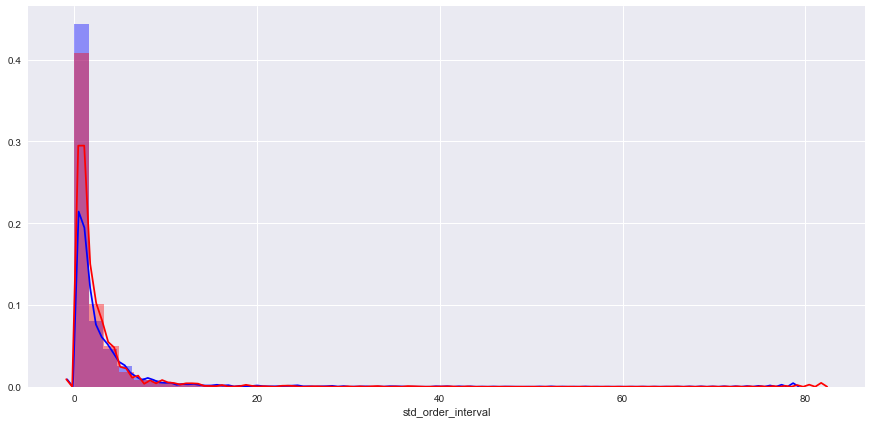

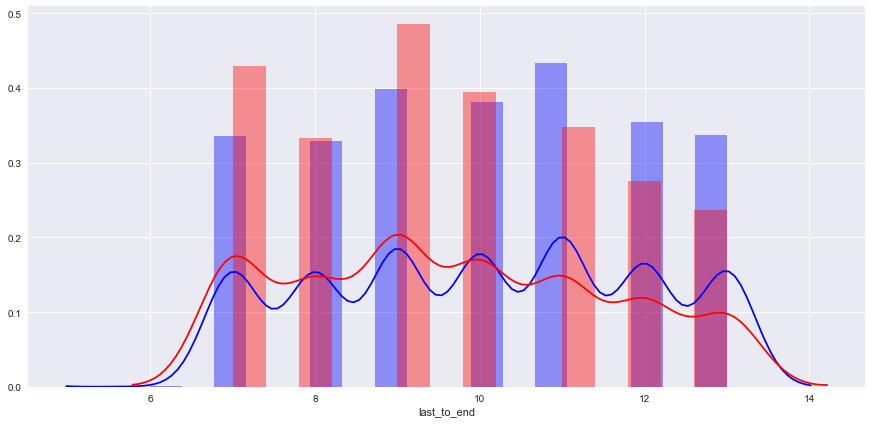

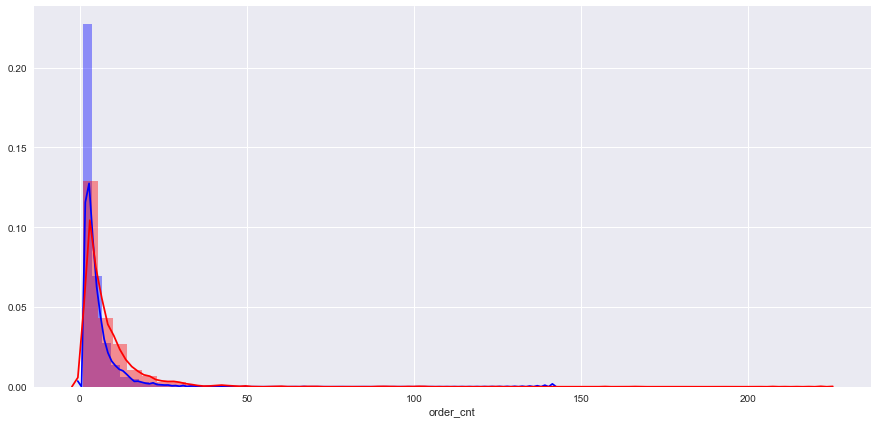

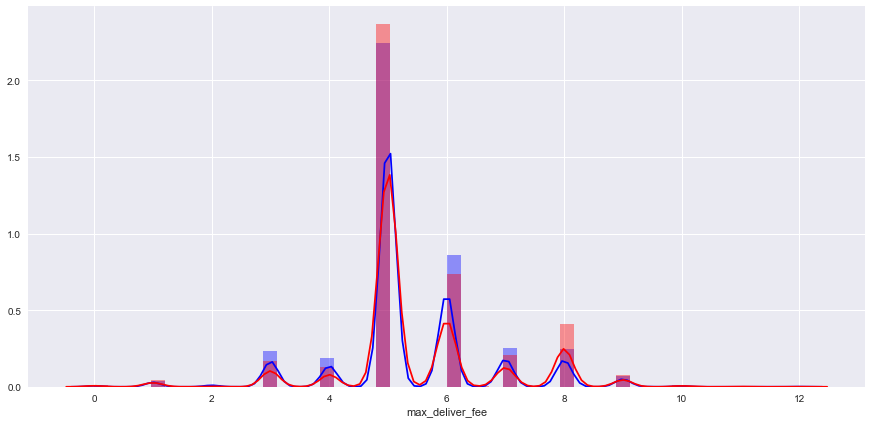

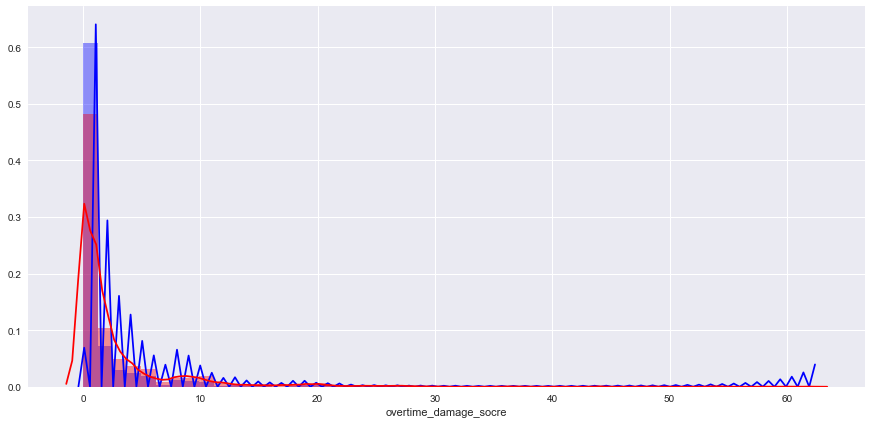

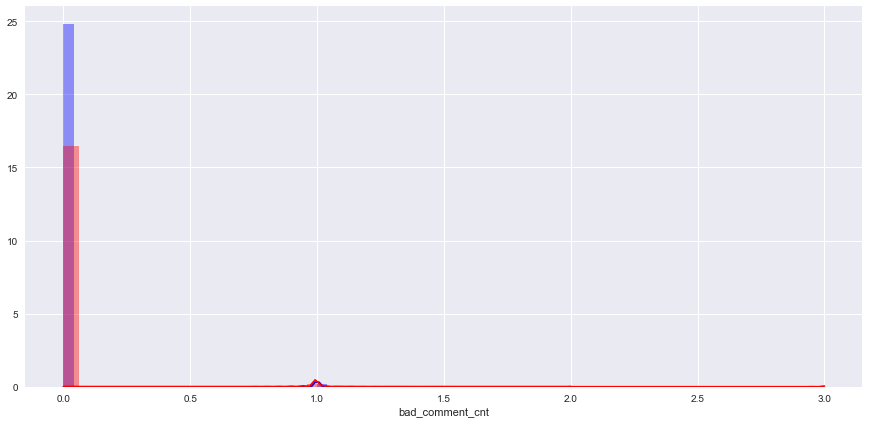

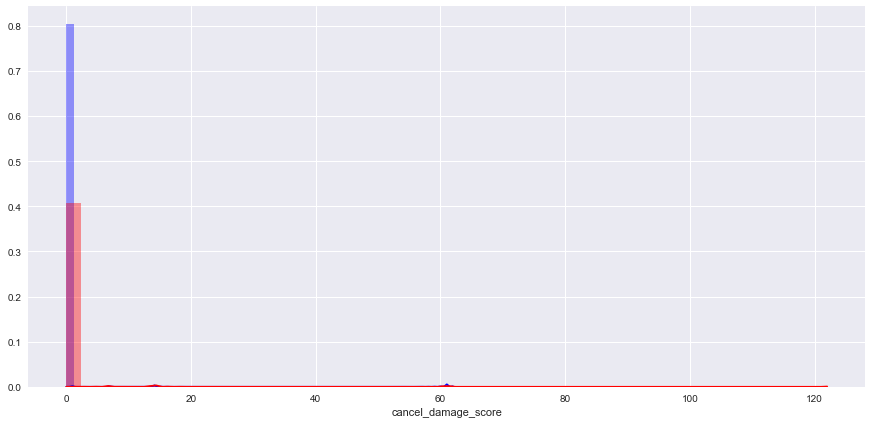

In [56]:
for col in features.features.values:
    plt.figure(figsize=(15,7))
    sns.distplot(df1[col].dropna(),label='non_churn',color='blue')
    sns.distplot(df2[col].dropna(),label='churn',color='red')

** 对平均客单价进行离散化处理，观察一下他和其他变量以及因变量的交互情况。**

In [57]:
user_churn.avg_order_price.describe()

count    10871.000000
mean        30.605102
std         22.989415
min          1.000000
25%         20.867414
50%         25.632857
75%         33.000000
max        963.000000
Name: avg_order_price, dtype: float64

In [58]:
def partition(x):
    if x<20:
        return '<20'
    elif x>=20 and x<30:
        return '20-30'
    else:
        return '>=30'

In [59]:
user_churn['avg_order_price_1']=user_churn['avg_order_price'].apply(partition)

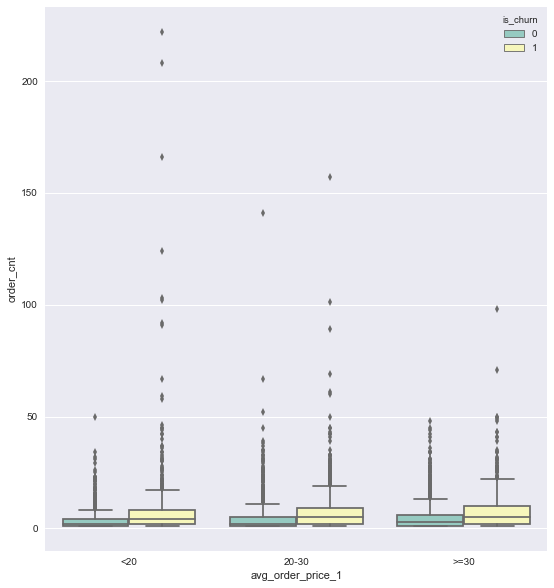

In [60]:
fig, ax=plt.subplots(figsize=(9,10))
sns.boxplot(x='avg_order_price_1',y='order_cnt',hue='is_churn',data=user_churn,order=['<20','20-30','>=30'],palette="Set3")

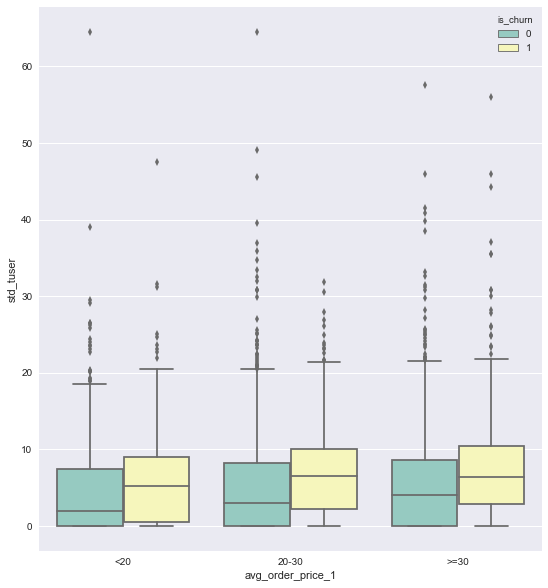

In [61]:
fig, ax=plt.subplots(figsize=(9,10))
sns.boxplot(x='avg_order_price_1',y='std_tuser',hue='is_churn',data=user_churn[user_churn.std_tuser<=100],order=['<20','20-30','>=30'],palette="Set3")

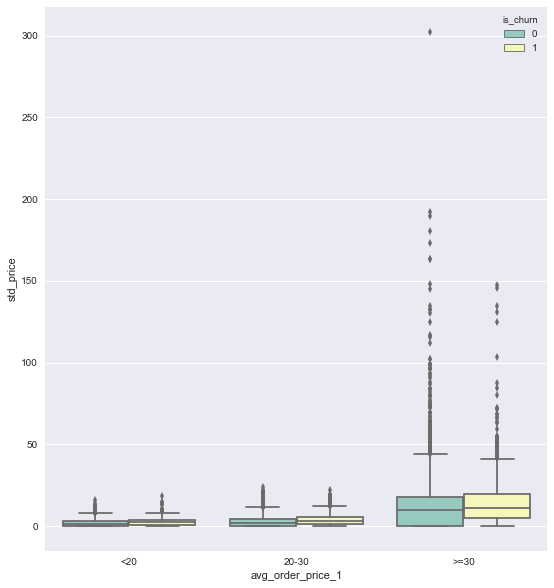

In [62]:
fig, ax=plt.subplots(figsize=(9,10))
sns.boxplot(x='avg_order_price_1',y='std_price',hue='is_churn',data=user_churn[user_churn.std_tuser<=100],order=['<20','20-30','>=30'],palette="Set3")

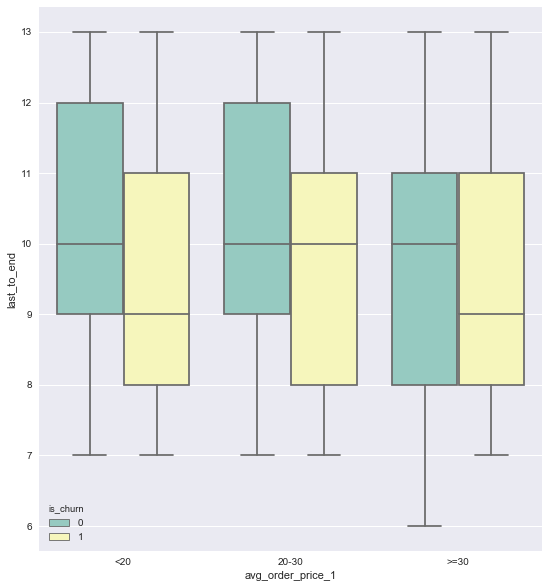

In [63]:
fig, ax=plt.subplots(figsize=(9,10))
sns.boxplot(x='avg_order_price_1',y='last_to_end',hue='is_churn',data=user_churn[user_churn.std_tuser<=100],order=['<20','20-30','>=30'],palette="Set3")

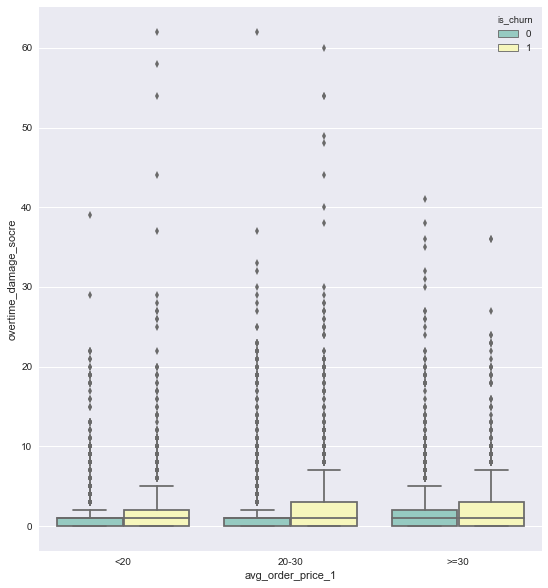

In [64]:
fig, ax=plt.subplots(figsize=(9,10))
sns.boxplot(x='avg_order_price_1',y='overtime_damage_socre',hue='is_churn',data=user_churn[user_churn.std_tuser<=100],order=['<20','20-30','>=30'],palette="Set3")

** 通过一些交互的图形信息，可以看出在不同的客单价分类下，流失用户和非流失用户的下单总量、沉默时长、客单价的波动情况、t用户的波动情况有着不同的分布。**